## Lab 3 - Basic Artificial Neural Network

Here we will build a very rudimentary Artificial Neural Network (ANN) and use it to solve some basic classification problems. This example is implemented using only basic math and linear algebra functions, which will allow us to study how each aspect of the network works, and to gain an intuitive understanding of its functions. In future labs we will use pre-built libraries such as Keras which automate and optimize much of these functions, making the network much faster and easier to use.

The code and MNIST test data is taken directly from [http://neuralnetworksanddeeplearning.com/](http://neuralnetworksanddeeplearning.com/) by [Michael Nielsen](http://michaelnielsen.org/). Please review the [first chapter](http://neuralnetworksanddeeplearning.com/chap1.html) of the book for a thorough explanation of the code.

In [1]:
import random
import numpy as np

In [2]:
class Network(object):
    
    def __init__(self, sizes):
        
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1.  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers."""
        
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                       for x, y in zip(sizes[:-1], sizes[1:])]
        
    def feedforward (self, a):
        
        #Return the output of the network if "a" is input.
        
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a
    
    def SGD(self, training_data, epochs, mini_batch_size, eta,
            test_data=None):
        
        """Train the neural network using mini-batch stochastic
        gradient descent.  The "training_data" is a list of tuples
        "(x, y)" representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory.  If "test_data" is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""

        if test_data: n_test = len(test_data)
        n = len(training_data)
        for j in xrange(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in xrange(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            
            if test_data:
                print "Epoch {0}: {1} / {2}".format(
                    j, self.evaluate(test_data), n_test)
            else:
                print "Epoch {0} complete".format(j)
    
    def update_mini_batch(self, mini_batch, eta):
        
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The "mini_batch" is a list of tuples "(x, y)", and "eta"
        is the learning rate."""

        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(eta/len(mini_batch))*nw 
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb 
                       for b, nb in zip(self.biases, nabla_b)]
        
    def backprop(self, x, y):
        
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * \
            sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        
        """Note that the variable l in the loop below is used a little
        differently to the notation in Chapter 2 of the book.  Here,
        l = 1 means the last layer of neurons, l = 2 is the
        second-last layer, and so on.  It's a renumbering of the
        scheme in the book, used here to take advantage of the fact
        that Python can use negative indices in lists."""
        
        for l in xrange(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def evaluate(self, test_data):
        
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return (output_activations-y)

In [3]:
def sigmoid(z):
#     The sigmoid function.
    return 1.0/(1.0 + np.exp(-z))

def sigmoid_prime(z):
#     Derivative of the sigmoid function.
    return sigmoid(z)*(1-sigmoid(z))

### Iris dataset example

Now we will test our basic artificial neural network on a very simple classification problem. First we will use the [seaborn data visualization library](https://stanford.edu/~mwaskom/software/seaborn/) to load the ['iris' dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set), 
which consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor), with four features measuring the length and the width of each flower's sepals and petals. After we load the data we will vizualize it using some functions in seaborn.

     sepal_length  sepal_width  petal_length  petal_width     species
111           6.4          2.7           5.3          1.9   virginica
126           6.2          2.8           4.8          1.8   virginica
107           7.3          2.9           6.3          1.8   virginica
87            6.3          2.3           4.4          1.3  versicolor
83            6.0          2.7           5.1          1.6  versicolor


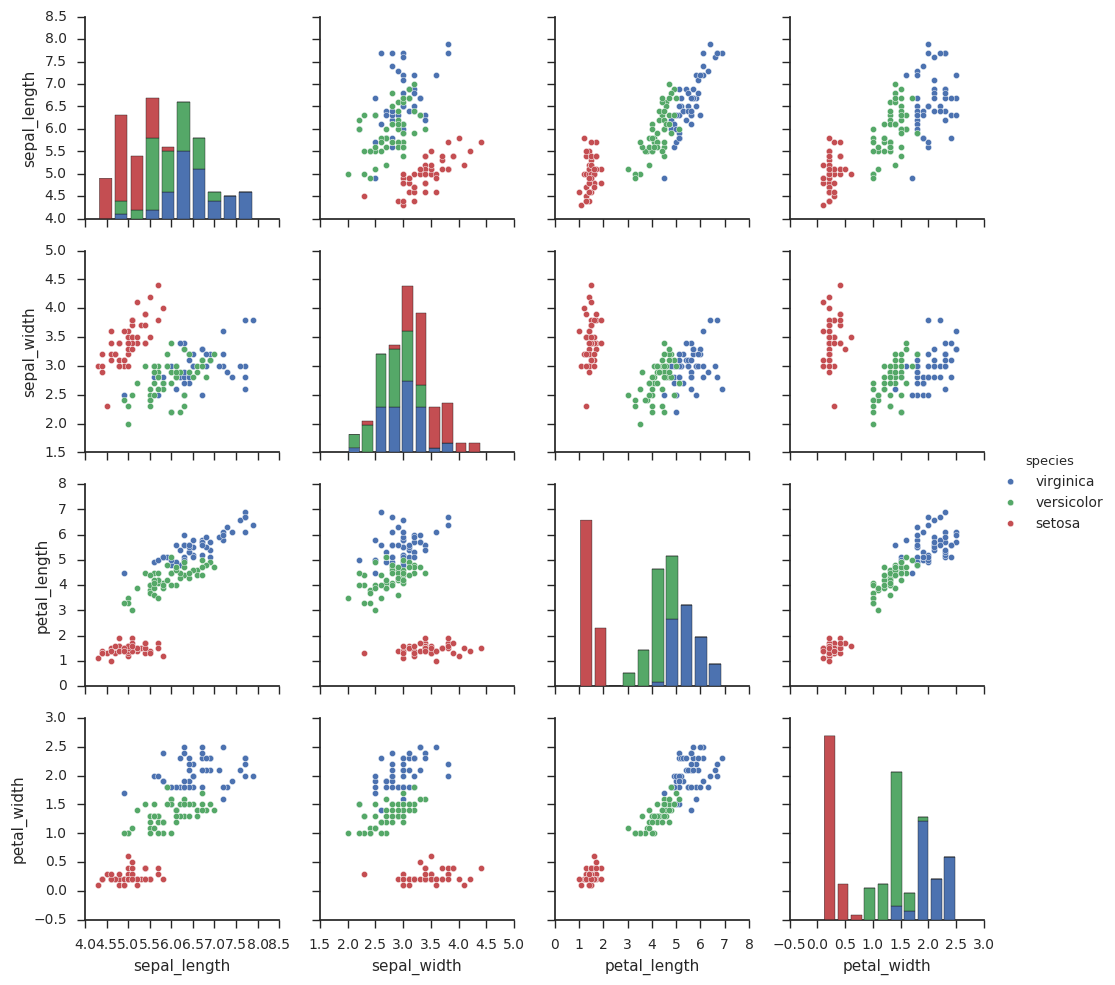

In [4]:
%matplotlib inline
import seaborn as sns; sns.set(style="ticks", color_codes=True)
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle

iris_data = sns.load_dataset("iris")

# randomly shuffle data
iris_data = shuffle(iris_data)

# print first 5 data points
print iris_data[:5]

# create pairplot of iris data
g = sns.pairplot(iris_data, hue="species")

Next, we will prepare the data set for training in our ANN. In order to work with our functions, the data needs to be converted to numpy format, split into feature and target sets, and then recombined as separate lists within a single dataset. Finally, we split the data set into training and testing sets, and convert the targets of the training set to 'one-hot' encoding (OHE). OHE takes each piece of categorical data and converts it to a list of binary values the length of which is equal to the number of categories, and the position of the current category denoted with a '1' and '0' for all others. For example, in our dataset we have 3 possible categories: versicolor, virginica, and setosa. After applying OHE, versicolor becomes [1,0,0], virginica becomes [0,1,0], and setosa becomes [0,0,1]. OHE is a standard format for target data as it allows easy application of the cost function during training.

In [5]:
# convert iris data to numpy format
iris_array = iris_data.as_matrix()

# split data into feature and 
X = iris_array[:, :4].astype(float)
y = iris_array[:, -1]

_, y = np.unique(y, return_inverse=True)
y = y.reshape(-1,1)

# create on-hot encoding function
enc = OneHotEncoder()
enc.fit(y)

# combine feature and target data
data = []
for i in range(X.shape[0]):
    data.append(tuple([X[i].reshape(-1,1), y[i][0]]))

# split data into training and test sets
trainingSplit = int(.8 * len(data))
training_data = data[:trainingSplit]
test_data = data[trainingSplit:]

# convert training targets to on-hot encoding
training_data = [[_x, enc.transform(_y.reshape(-1,1)).toarray().reshape(-1,1)] for _x, _y in training_data]

In [6]:
net = Network([4, 25, 3])
net.SGD(training_data, 21, 10, .1, test_data=test_data)

Epoch 0: 7 / 30
Epoch 1: 7 / 30
Epoch 2: 7 / 30
Epoch 3: 10 / 30
Epoch 4: 18 / 30
Epoch 5: 26 / 30
Epoch 6: 26 / 30
Epoch 7: 25 / 30
Epoch 8: 26 / 30
Epoch 9: 26 / 30
Epoch 10: 26 / 30
Epoch 11: 26 / 30
Epoch 12: 26 / 30
Epoch 13: 29 / 30
Epoch 14: 29 / 30
Epoch 15: 28 / 30
Epoch 16: 30 / 30
Epoch 17: 29 / 30
Epoch 18: 30 / 30
Epoch 19: 30 / 30
Epoch 20: 30 / 30


### MNIST dataset example

Next, we will test our ANN on another, slightly more difficult classification problem. The data set we'll be using is called MNIST, which contains tens of thousands of scanned images of handwritten digits, classified according to the digit type from 0-9. The name MNIST comes from the fact that it is a Modified (M) version of a dataset originally developed by the United States' National Institute of Standards and Technology (NIST). This is a very popular dataset used to measure the effectiveness of Machine Learning models for image recongnition. This time we don't have to do as much data management since the data is already provided in the right format [here](https://github.com/mnielsen/neural-networks-and-deep-learning/tree/master/data). 

We will get into more details about working with images and proper data formats for image data in later labs, but you can already use this data to test the effectiveness of our network. With the default settings you should be able to get a classification accuracy of 95% in the test set.

In [7]:
import mnist_loader

training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

We can use the matplotlib library to visualize one of the training images. In the data set, the pixel values of each 28x28 pixel image is encoded in a straight list of 784 numbers, so before we visualize it we have to use numpy's reshape function to convert it back t

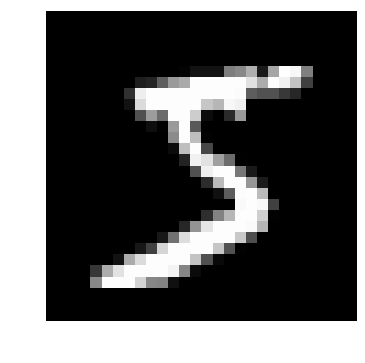

In [ ]:
%matplotlib inline
import matplotlib.pylab as plt

img = training_data[0][0][:,0].reshape((28,28))

fig = plt.figure()
plt.imshow(img, interpolation='nearest', vmin = 0, vmax = 1, cmap=plt.cm.gray)
plt.axis('off')
plt.show()

In [ ]:
net = Network([784, 30, 10])
net.SGD(training_data, 30, 10, 3.0, test_data=test_data)

plt.plot(results)
plt.ylabel('accuracy (%)')
plt.ylim([0,100.0])
plt.show()

Epoch 0 : 16 / 36 - 44.44 % acc
Epoch 1 : 16 / 36 - 44.44 % acc
Epoch 2 : 16 / 36 - 44.44 % acc
Epoch 3 : 16 / 36 - 44.44 % acc
Epoch 4 : 16 / 36 - 44.44 % acc
Epoch 5 : 16 / 36 - 44.44 % acc
Epoch 6 : 16 / 36 - 44.44 % acc
Epoch 7 : 16 / 36 - 44.44 % acc
Epoch 8 : 16 / 36 - 44.44 % acc
Epoch 9 : 16 / 36 - 44.44 % acc
Epoch 10 : 16 / 36 - 44.44 % acc
Epoch 11 : 30 / 36 - 83.33 % acc
Epoch 12 : 29 / 36 - 80.56 % acc
Epoch 13 : 29 / 36 - 80.56 % acc
Epoch 14 : 30 / 36 - 83.33 % acc
Epoch 15 : 29 / 36 - 80.56 % acc
Epoch 16 : 29 / 36 - 80.56 % acc
Epoch 17 : 30 / 36 - 83.33 % acc
Epoch 18 : 31 / 36 - 86.11 % acc
Epoch 19 : 29 / 36 - 80.56 % acc
Epoch 20 : 29 / 36 - 80.56 % acc
Epoch 21 : 31 / 36 - 86.11 % acc
Epoch 22 : 31 / 36 - 86.11 % acc
Epoch 23 : 32 / 36 - 88.89 % acc
Epoch 24 : 30 / 36 - 83.33 % acc
Epoch 25 : 33 / 36 - 91.67 % acc
Epoch 26 : 31 / 36 - 86.11 % acc
Epoch 27 : 33 / 36 - 91.67 % acc
Epoch 28 : 31 / 36 - 86.11 % acc
Epoch 29 : 32 / 36 - 88.89 % acc
Epoch 30 : 32 / 36 -

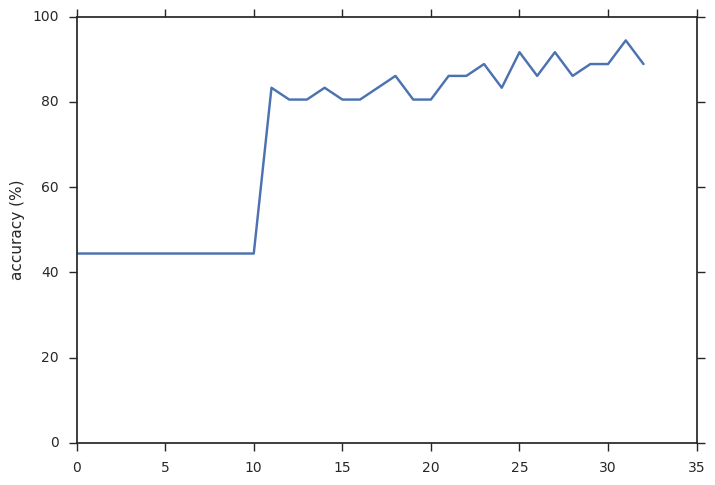

In [18]:
%matplotlib inline
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle

class Network(object):
    
    def __init__(self, sizes):
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]
        
    def feedforward (self, a):
        """Return the output of the network if "a" is input. The np.dot() 
        function computes the matrix multiplication between the weight and input
        matrices for each set of layers. When used with numpy arrays, the '+'
        operator performs matrix addition."""
        
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a
    
    def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None):
        
        """Train the neural network using mini-batch stochastic
        gradient descent.  The "training_data" is a list of tuples
        "(x, y)" representing the training inputs and the desired
        outputs.  The other non-optional parameters specify the number 
        of epochs, size of each mini-batch, and the learning rate.  
        If "test_data" is provided then the network will be evaluated 
        against the test data after each epoch, and partial progress 
        printed out.  This is useful for tracking progress, but slows
        things down substantially."""
        
        # create an empty array to store the accuracy results from each epoch
        results = []

        n = len(training_data)
        
        if test_data: 
            n_test = len(test_data)
            
        # this is the code for one training step, done once for each epoch
        for j in xrange(epochs):
            
            # before each epoch, the data is randomly shuffled
            random.shuffle(training_data)
            
            # training data is broken up into individual mini-batches
            # 
            mini_batches = [ training_data[k:k+mini_batch_size] 
                            for k in xrange(0, n, mini_batch_size) ]
            
            # then each mini-batch is used to update the parameters of the 
            # network using backpropagation and the specified learning rate
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            
            # if a test data set is provided, the accuracy results 
            # are displayed and stored in the 'results' array
            if test_data:
                num_correct = self.evaluate(test_data)
                accuracy = "%.2f" % (100 * (float(num_correct) / n_test))
                print "Epoch", j, ":", num_correct, "/", n_test, "-", accuracy, "% acc"
                results.append(accuracy)
            else:
                print "Epoch", j, "complete"
                
        return results
    
    def update_mini_batch(self, mini_batch, eta):
        
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The "mini_batch" is a list of tuples "(x, y)", and "eta"
        is the learning rate."""
        

        nabla_b = [np.zeros(b.shape) for b in self.biases] #bias matrices for all layers
        nabla_w = [np.zeros(w.shape) for w in self.weights] #weight matrices for all layers
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(eta/len(mini_batch))*nw 
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb 
                       for b, nb in zip(self.biases, nabla_b)]
        
    def backprop(self, x, y):
        
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer, including the first layer of inputs
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        #list[-i] is the ith item counting from back
        delta = self.cost_derivative(activations[-1], y) * \
            sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        
        """Note that the variable l in the loop below is used a little
        differently to the notation in Chapter 2 of the book.  Here,
        l = 1 means the last layer of neurons, l = 2 is the
        second-last layer, and so on.  It's a renumbering of the
        scheme in the book, used here to take advantage of the fact
        that Python can use negative indices in lists."""
        
        for l in xrange(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def evaluate(self, test_data):
        
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation.
        
        Numpy's argmax() function returns the position of the 
        largest element in an array. We first create a list of 
        predicted value and target value pairs, and then count 
        the number of times those values match to get the total 
        number correct."""
        
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return (output_activations-y)
def sigmoid(z):
#     The sigmoid activation function.
    return 1.0/(1.0 + np.exp(-z))

def sigmoid_prime(z):
#     Derivative of the sigmoid function.
    return sigmoid(z)*(1-sigmoid(z))

wine_data = np.loadtxt(open("./data/wine.csv","rb"),delimiter=",")

wine_data = shuffle(wine_data)

X = wine_data[:,1:]
y = wine_data[:, 0]

# normalize the data per feature by dividing by the maximum value in each column
X = X / X.max(axis=0)

# convert the textual category data to integer using numpy's unique() function
_, y = np.unique(y, return_inverse=True)

# convert the list of targets to a vertical matrix with the dimensions [1 x number of samples]
# this is necessary for later computation
y = y.reshape(-1,1)

# combine feature and target data into a new python array
data = []
for i in range(X.shape[0]):
    data.append(tuple([X[i].reshape(-1,1), y[i][0]]))
    
# split data into training and test sets
trainingSplit = int(.8 * len(data))
training_data = data[:trainingSplit]
test_data = data[trainingSplit:]

# create an instance of the one-hot encoding function from the sci-kit learn library
enc = OneHotEncoder()

# use the function to figure out how many categories exist in the data
enc.fit(y)

# convert only the target data in the training set to one-hot encoding
training_data = [[_x, enc.transform(_y.reshape(-1,1)).toarray().reshape(-1,1)] for _x, _y in training_data]

# define the network
net = Network([13, 32, 3])

# train the network using SGD, and output the results
results = net.SGD(training_data, 33, 11, 0.2, test_data=test_data)

# visualize the results
plt.plot(results)
plt.ylabel('accuracy (%)')
plt.ylim([0,100.0])
plt.show()